In [1]:
from rdkit import Chem
import sys
import os
import useful_rdkit_utils as uru
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
import itertools
import pandas as pd
from collections import Counter
import mols2grid
from tdc.single_pred import ADME
from Filtering_functions import filter_molecules
import glob
from rdkit.Chem import inchi
import molvs
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

In [2]:
# Get the current working directory
current_dir = os.getcwd()
print(current_dir)
# Get the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
print(parent_dir)
# Add the parent directory to sys.path
sys.path.append(parent_dir)

/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/Decomopt
/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model


Set the default image size

In [3]:
uru.rd_set_image_size(300,300)

### Reading the data from Decomopt

See if they are valid or not and standardize them:

In [4]:
standardizer = molvs.standardize.Standardizer()

def standardize_mol(mol):
    try:
        mol = standardizer.standardize(mol)
        mol = standardizer.fragment_parent(mol, skip_standardize=True)
        mol = standardizer.tautomer_parent(mol, skip_standardize=True)
        mol = standardizer.isotope_parent(mol, skip_standardize=True)
        mol = standardizer.charge_parent(mol, skip_standardize=True)
        return mol
    except:
        return None

In [6]:
smi_list = []
with open('combined_smiles_decompopt_10000.smi') as f:
    for smi in f:
        smi_list.append(smi.strip())
standardized_smiles_list = []
for smi in tqdm(smi_list, desc="Standardizing SMILES", unit="mols"):
    mol = Chem.MolFromSmiles(smi)
    mol = standardize_mol(mol)
    if mol:
        standardized_smiles_list.append(Chem.MolToSmiles(mol))

print(len(smi_list))
len(standardized_smiles_list)

Standardizing SMILES:  24%|██▍       | 2149/8913 [05:02<09:14, 12.19mols/s] [14:47:44] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 6
[14:47:44] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 6 8 11
[14:47:44] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 6 8 11
[14:47:44] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 6 8 11
Standardizing SMILES:  73%|███████▎  | 6482/8913 [11:05<21:24,  1.89mols/s]  [14:53:48] Can't kekulize mol.  Unkekulized atoms: 12 13 14 22 30
[14:53:48] Can't kekulize mol.  Unkekulized atoms: 12 13 14 22 30
[14:53:48] Can't kekulize mol.  Unkekulized atoms: 12 13 14 22 30
Standardizing SMILES:  76%|███████▌  | 6781/8913 [11:34<18:59,  1.87mols/s][14:54:16] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 29 30
[14:54:16] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 29 30
[14:54:16] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 29 30
[14:54:16] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 29 30
[14:54:16] Can't kekulize mol.  Unkekulized ato

8913


8913

In [7]:
with open('combined_SMILES_10000_Decompopt_standardized.txt', 'w') as f:
    for item in standardized_smiles_list:
        f.write("%s\n" % item)

Convert SMILES and name of them to a dataframe

In [8]:
df = pd.DataFrame(standardized_smiles_list, columns=['SMILES'])
df

SMILES
0     CCC(NCC(N)c1cnn(C)n1)C(O)CNC(=O)c1cc2c(cc1OC1C...
1     CC(=O)c1cc(NC(=O)c2cc(C(C)c3ccccc3)cc(O)c2O)n(...
2     C=C(C)CC(C(c1nccc(C2CCC(C)C2)n1)C(C)CCO)N1CC2N...
3     NC(=O)CCC1C=CC(C(=O)O)c2ccc(-c3ccccc3)cc2OC1NC...
4     CNC(=O)N1CC2C=CCC=CC2CC1C(O)C(CCCc1ccccc1)C(C(...
...                                                 ...
8908                               O=C1CC(O)C(CO)CCNC1O
8909                               CC1=CC2CC(O)COC2CC1O
8910                              Oc1ccc2c(c1O)C(O)CC2O
8911                           O=C(O)C1COC2CC1(C1CC1)O2
8912                            O=c1cc2cccc[nH]c-2nc1=O

[8913 rows x 1 columns]

Add an RDKit molecule to the dataframe

In [9]:
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)

Strip salts from the molecule

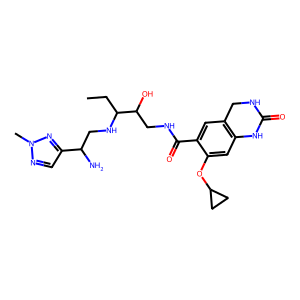

In [10]:
df.mol = df.mol.apply(uru.get_largest_fragment)
df.mol[0]

Instantiate a RingSystemFinder object and find ring systems for the molecules in df

In [11]:
ring_system_finder = uru.RingSystemFinder()
df['ring_sytems'] = df.mol.apply(ring_system_finder.find_ring_systems)
df.ring_sytems

0              [c1cn[nH]n1, O=C1NCc2ccccc2N1, C1CC1]
1       [c1cc[nH]c1, c1ccccc1, c1ccccc1, O=C1CCCCC1]
2               [c1cncnc1, C1CCCC1, O=C1NCC2NCNC2N1]
3             [C1=CCc2ccccc2OCC1, c1ccccc1, C1CNCN1]
4                      [C1=CC2CCNCC2C=CC1, c1ccccc1]
                            ...                     
8908                                  [O=C1CCCCCNC1]
8909                               [C1=CC2CCCOC2CC1]
8910                               [c1ccc2c(c1)CCC2]
8911                          [C1CC2CC(O1)O2, C1CC1]
8912                       [O=c1cc2cccc[nH]c-2nc1=O]
Name: ring_sytems, Length: 8913, dtype: object

In [12]:
df.ring_sytems.values

array([list(['c1cn[nH]n1', 'O=C1NCc2ccccc2N1', 'C1CC1']),
       list(['c1cc[nH]c1', 'c1ccccc1', 'c1ccccc1', 'O=C1CCCCC1']),
       list(['c1cncnc1', 'C1CCCC1', 'O=C1NCC2NCNC2N1']), ...,
       list(['c1ccc2c(c1)CCC2']), list(['C1CC2CC(O1)O2', 'C1CC1']),
       list(['O=c1cc2cccc[nH]c-2nc1=O'])], dtype=object)

See how many times each ring system occurs

In [13]:
ring_system_list = list(itertools.chain.from_iterable(df.ring_sytems.values))
ring_count_df = pd.DataFrame(Counter(ring_system_list).items(),columns=["SMILES","Count"]) ### Convert a dictionary to a DataFrame.
ring_count_df.sort_values("Count",ascending=False,inplace=True)
ring_count_df

SMILES  Count
4                             c1ccccc1   3193
7                              C1CCCC1    555
54                             C1CCOC1    506
30                           C1CCCCCC1    453
19                            C1CCCCC1    371
...                                ...    ...
1387           O=C1CCC2C1CCCCC21C2CC21      1
1388  O=C1CCc2[nH]c3cnoc3c2-c2ccccc2C1      1
1389                  C=C1CC=C2CCCCC12      1
1390                C1CC2C3CC1C1CC3C12      1
1377                       C=C1CCCC1=O      1

[3350 rows x 2 columns]

View the ring system frequencies

In [14]:
mols2grid.display(ring_count_df,subset=["img","Count"])

MolGridWidget()

The RingSystemLookup object has a dictionary of how many times each ring system occurs in the ChEMBL database.  We can use this object to evaluate the molecules in df.

In [17]:
ring_system_lookup = uru.RingSystemLookup()
res = df.mol.apply(ring_system_lookup.process_mol)

In [18]:
res

0       [(c1cn[nH]n1, 41492), (O=C1NCc2ccccc2N1, 980),...
1       [(c1cc[nH]c1, 34250), (c1ccccc1, 2568039), (c1...
2       [(c1cncnc1, 100599), (C1CCCC1, 38317), (O=C1NC...
3       [(C1=CCc2ccccc2OCC1, 0), (c1ccccc1, 2568039), ...
4           [(C1=CC2CCNCC2C=CC1, 0), (c1ccccc1, 2568039)]
                              ...                        
8908                                  [(O=C1CCCCCNC1, 0)]
8909                               [(C1=CC2CCCOC2CC1, 0)]
8910                           [(c1ccc2c(c1)CCC2, 10459)]
8911                 [(C1CC2CC(O1)O2, 1), (C1CC1, 90040)]
8912                       [(O=c1cc2cccc[nH]c-2nc1=O, 0)]
Name: mol, Length: 8913, dtype: object

In [19]:
df[['min_ring','min_freq']] = res.apply(uru.get_min_ring_frequency).tolist()
df

SMILES  \
0     CCC(NCC(N)c1cnn(C)n1)C(O)CNC(=O)c1cc2c(cc1OC1C...   
1     CC(=O)c1cc(NC(=O)c2cc(C(C)c3ccccc3)cc(O)c2O)n(...   
2     C=C(C)CC(C(c1nccc(C2CCC(C)C2)n1)C(C)CCO)N1CC2N...   
3     NC(=O)CCC1C=CC(C(=O)O)c2ccc(-c3ccccc3)cc2OC1NC...   
4     CNC(=O)N1CC2C=CCC=CC2CC1C(O)C(CCCc1ccccc1)C(C(...   
...                                                 ...   
8908                               O=C1CC(O)C(CO)CCNC1O   
8909                               CC1=CC2CC(O)COC2CC1O   
8910                              Oc1ccc2c(c1O)C(O)CC2O   
8911                           O=C(O)C1COC2CC1(C1CC1)O2   
8912                            O=c1cc2cccc[nH]c-2nc1=O   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x7979c60df290>   
1     <rdkit.Chem.rdchem.Mol object at 0x7979c60df300>   
2     <rdkit.Chem.rdchem.Mol object at 0x7979c60df370>   
3     <rdkit.Chem.rdchem.Mol object at 0x7979c60df3e0>   
4     <rdkit.Chem.rdchem.Mol object at 0x7979c60df450>   
...                                                ...   
8908  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8d60>   
8909  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8dd0>   
8910  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8e40>   
8911  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8eb0>   
8912  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8f20>   

                                       ring_sytems                 min_ring  \
0            [c1cn[nH]n1, O=C1NCc2ccccc2N1, C1CC1]         O=C1NCc2ccccc2N1   
1     [c1cc[nH]c1, c1ccccc1, c1ccccc1, O=C1CCCCC1]               O=C1CCCCC1   
2             [c1cncnc1, C1CCCC1, O=C1NCC2NCNC2N1]          O=C1NCC2NCNC2N1   
3           [C1=CCc2ccccc2OCC1, c1ccccc1, C1CNCN1]        C1=CCc2ccccc2OCC1   
4                    [C1=CC2CCNCC2C=CC1, c1ccccc1]        C1=CC2CCNCC2C=CC1   
...                                            ...                      ...   
8908                                [O=C1CCCCCNC1]             O=C1CCCCCNC1   
8909                             [C1=CC2CCCOC2CC1]          C1=CC2CCCOC2CC1   
8910                             [c1ccc2c(c1)CCC2]          c1ccc2c(c1)CCC2   
8911                        [C1CC2CC(O1)O2, C1CC1]            C1CC2CC(O1)O2   
8912                     [O=c1cc2cccc[nH]c-2nc1=O]  O=c1cc2cccc[nH]c-2nc1=O   

     min_freq  
0         980  
1         862  
2           0  
3           0  
4           0  
...       ...  
8908        0  
8909        0  
8910    10459  
8911        1  
8912        0  

[8913 rows x 5 columns]

In [20]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

### Check how many molecules are unique the ring frequency of them

How many molecules are unique using inChI?

In [21]:
df['inchi'] = df.mol.apply(Chem.MolToInchi)
df = df.drop_duplicates("inchi", keep="first", ignore_index=True)
df

[15:00:23] WARNING: Omitted undefined stereo

[15:00:23] WARNING: Omitted undefined stereo

[15:00:23] WARNING: Omitted undefined stereo

[15:00:23] WARNING: Omitted undefined stereo

[15:00:23] WARNING: Omitted undefined stereo

[15:00:23] WARNING: Omitted undefined stereo

[15:00:23] WARNING: Omitted undefined stereo

[15:00:23] WARNING: Omitted undefined stereo

[15:00:23] WARNING: Omitted undefined stereo

[15:00:23] WARNING: Omitted undefined stereo

[15:00:23] WARNING: Omitted undefined stereo

[15:00:23] WARNING: Omitted undefined stereo

[15:00:23] WARNING: Omitted undefined stereo

[15:00:23] WARNING: Omitted undefined stereo

[15:00:23] WARNING: Omitted undefined stereo

[15:00:23] WARNING: Omitted undefined stereo

[15:00:23] WARNING: Omitted undefined stereo

[15:00:23] WARNING: Omitted undefined stereo

[15:00:23] WARNING: Omitted undefined stereo

[15:00:23] WARNING: Omitted undefined stereo

[15:00:23] WARNING: Omitted undefined stereo

[15:00:23] WARNING: Omitted undefi

SMILES  \
0     CCC(NCC(N)c1cnn(C)n1)C(O)CNC(=O)c1cc2c(cc1OC1C...   
1     CC(=O)c1cc(NC(=O)c2cc(C(C)c3ccccc3)cc(O)c2O)n(...   
2     C=C(C)CC(C(c1nccc(C2CCC(C)C2)n1)C(C)CCO)N1CC2N...   
3     NC(=O)CCC1C=CC(C(=O)O)c2ccc(-c3ccccc3)cc2OC1NC...   
4     CNC(=O)N1CC2C=CCC=CC2CC1C(O)C(CCCc1ccccc1)C(C(...   
...                                                 ...   
8275                               O=C1CC(O)C(CO)CCNC1O   
8276                               CC1=CC2CC(O)COC2CC1O   
8277                              Oc1ccc2c(c1O)C(O)CC2O   
8278                           O=C(O)C1COC2CC1(C1CC1)O2   
8279                            O=c1cc2cccc[nH]c-2nc1=O   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x7979c60df290>   
1     <rdkit.Chem.rdchem.Mol object at 0x7979c60df300>   
2     <rdkit.Chem.rdchem.Mol object at 0x7979c60df370>   
3     <rdkit.Chem.rdchem.Mol object at 0x7979c60df3e0>   
4     <rdkit.Chem.rdchem.Mol object at 0x7979c60df450>   
...                                                ...   
8275  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8d60>   
8276  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8dd0>   
8277  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8e40>   
8278  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8eb0>   
8279  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8f20>   

                                       ring_sytems                 min_ring  \
0            [c1cn[nH]n1, O=C1NCc2ccccc2N1, C1CC1]         O=C1NCc2ccccc2N1   
1     [c1cc[nH]c1, c1ccccc1, c1ccccc1, O=C1CCCCC1]               O=C1CCCCC1   
2             [c1cncnc1, C1CCCC1, O=C1NCC2NCNC2N1]          O=C1NCC2NCNC2N1   
3           [C1=CCc2ccccc2OCC1, c1ccccc1, C1CNCN1]        C1=CCc2ccccc2OCC1   
4                    [C1=CC2CCNCC2C=CC1, c1ccccc1]        C1=CC2CCNCC2C=CC1   
...                                            ...                      ...   
8275                                [O=C1CCCCCNC1]             O=C1CCCCCNC1   
8276                             [C1=CC2CCCOC2CC1]          C1=CC2CCCOC2CC1   
8277                             [c1ccc2c(c1)CCC2]          c1ccc2c(c1)CCC2   
8278                        [C1CC2CC(O1)O2, C1CC1]            C1CC2CC(O1)O2   
8279                     [O=c1cc2cccc[nH]c-2nc1=O]  O=c1cc2cccc[nH]c-2nc1=O   

     min_freq                                              inchi  
0         980  InChI=1S/C22H32N8O4/c1-3-16(24-9-15(23)18-10-2...  
1         862  InChI=1S/C27H28N2O5/c1-16(18-7-4-3-5-8-18)19-1...  
2           0  InChI=1S/C25H41N7O2/c1-14(2)11-20(32-13-19-22(...  
3           0  InChI=1S/C24H30N6O4/c25-19(31)11-8-14-6-10-17(...  
4           0  InChI=1S/C26H34N2O6/c1-27-26(34)28-16-19-13-7-...  
...       ...                                                ...  
8275        0  InChI=1S/C8H15NO4/c10-4-5-1-2-9-8(13)7(12)3-6(...  
8276        0  InChI=1S/C10H16O3/c1-6-2-7-3-8(11)5-13-10(7)4-...  
8277    10459  InChI=1S/C9H10O4/c10-5-2-1-4-6(11)3-7(12)8(4)9...  
8278        1  InChI=1S/C9H12O4/c10-8(11)6-4-12-7-3-9(6,13-7)...  
8279        0  InChI=1S/C9H6N2O2/c12-7-5-6-3-1-2-4-10-8(6)11-...  

[8280 rows x 6 columns]

How many molecules contains ring structure?

In [22]:
df_ring = df[df.min_freq != -1]
df_ring

SMILES  \
0     CCC(NCC(N)c1cnn(C)n1)C(O)CNC(=O)c1cc2c(cc1OC1C...   
1     CC(=O)c1cc(NC(=O)c2cc(C(C)c3ccccc3)cc(O)c2O)n(...   
2     C=C(C)CC(C(c1nccc(C2CCC(C)C2)n1)C(C)CCO)N1CC2N...   
3     NC(=O)CCC1C=CC(C(=O)O)c2ccc(-c3ccccc3)cc2OC1NC...   
4     CNC(=O)N1CC2C=CCC=CC2CC1C(O)C(CCCc1ccccc1)C(C(...   
...                                                 ...   
8275                               O=C1CC(O)C(CO)CCNC1O   
8276                               CC1=CC2CC(O)COC2CC1O   
8277                              Oc1ccc2c(c1O)C(O)CC2O   
8278                           O=C(O)C1COC2CC1(C1CC1)O2   
8279                            O=c1cc2cccc[nH]c-2nc1=O   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x7979c60df290>   
1     <rdkit.Chem.rdchem.Mol object at 0x7979c60df300>   
2     <rdkit.Chem.rdchem.Mol object at 0x7979c60df370>   
3     <rdkit.Chem.rdchem.Mol object at 0x7979c60df3e0>   
4     <rdkit.Chem.rdchem.Mol object at 0x7979c60df450>   
...                                                ...   
8275  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8d60>   
8276  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8dd0>   
8277  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8e40>   
8278  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8eb0>   
8279  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8f20>   

                                       ring_sytems                 min_ring  \
0            [c1cn[nH]n1, O=C1NCc2ccccc2N1, C1CC1]         O=C1NCc2ccccc2N1   
1     [c1cc[nH]c1, c1ccccc1, c1ccccc1, O=C1CCCCC1]               O=C1CCCCC1   
2             [c1cncnc1, C1CCCC1, O=C1NCC2NCNC2N1]          O=C1NCC2NCNC2N1   
3           [C1=CCc2ccccc2OCC1, c1ccccc1, C1CNCN1]        C1=CCc2ccccc2OCC1   
4                    [C1=CC2CCNCC2C=CC1, c1ccccc1]        C1=CC2CCNCC2C=CC1   
...                                            ...                      ...   
8275                                [O=C1CCCCCNC1]             O=C1CCCCCNC1   
8276                             [C1=CC2CCCOC2CC1]          C1=CC2CCCOC2CC1   
8277                             [c1ccc2c(c1)CCC2]          c1ccc2c(c1)CCC2   
8278                        [C1CC2CC(O1)O2, C1CC1]            C1CC2CC(O1)O2   
8279                     [O=c1cc2cccc[nH]c-2nc1=O]  O=c1cc2cccc[nH]c-2nc1=O   

     min_freq                                              inchi  
0         980  InChI=1S/C22H32N8O4/c1-3-16(24-9-15(23)18-10-2...  
1         862  InChI=1S/C27H28N2O5/c1-16(18-7-4-3-5-8-18)19-1...  
2           0  InChI=1S/C25H41N7O2/c1-14(2)11-20(32-13-19-22(...  
3           0  InChI=1S/C24H30N6O4/c25-19(31)11-8-14-6-10-17(...  
4           0  InChI=1S/C26H34N2O6/c1-27-26(34)28-16-19-13-7-...  
...       ...                                                ...  
8275        0  InChI=1S/C8H15NO4/c10-4-5-1-2-9-8(13)7(12)3-6(...  
8276        0  InChI=1S/C10H16O3/c1-6-2-7-3-8(11)5-13-10(7)4-...  
8277    10459  InChI=1S/C9H10O4/c10-5-2-1-4-6(11)3-7(12)8(4)9...  
8278        1  InChI=1S/C9H12O4/c10-8(11)6-4-12-7-3-9(6,13-7)...  
8279        0  InChI=1S/C9H6N2O2/c12-7-5-6-3-1-2-4-10-8(6)11-...  

[7604 rows x 6 columns]

In [23]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

SMILES  \
0     CCC(NCC(N)c1cnn(C)n1)C(O)CNC(=O)c1cc2c(cc1OC1C...   
1     CC(=O)c1cc(NC(=O)c2cc(C(C)c3ccccc3)cc(O)c2O)n(...   
5     CC(C)OC(c1ccc2c(c1)CC(N)NC2)c1cn(-c2ccccc2)cc1...   
7                          CN(CC(N)C(=O)O)C(=O)C1CCCOC1   
8     Cc1cc(C(CNc2cc3nn(C)nc3cc2-c2ccsc2)C(=O)O)cc(N...   
...                                                 ...   
8267                              OCC(O)C(O)C1(CO)OCC1O   
8268                            CC1NCC(O)C(O)C(O)C1(C)O   
8272                              CSC1CC(O)C(CO)C(O)C1O   
8274                              CCCC1(C(O)O)NOC(F)C1O   
8277                              Oc1ccc2c(c1O)C(O)CC2O   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x7979c60df290>   
1     <rdkit.Chem.rdchem.Mol object at 0x7979c60df300>   
5     <rdkit.Chem.rdchem.Mol object at 0x7979c60df4c0>   
7     <rdkit.Chem.rdchem.Mol object at 0x7979c60df5a0>   
8     <rdkit.Chem.rdchem.Mol object at 0x7979c60df610>   
...                                                ...   
8267  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd89e0>   
8268  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8a50>   
8272  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8c10>   
8274  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8cf0>   
8277  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8e40>   

                                          ring_sytems          min_ring  \
0               [c1cn[nH]n1, O=C1NCc2ccccc2N1, C1CC1]  O=C1NCc2ccccc2N1   
1        [c1cc[nH]c1, c1ccccc1, c1ccccc1, O=C1CCCCC1]        O=C1CCCCC1   
5            [c1ccc2c(c1)CCNC2, c1cc[nH]c1, c1ccccc1]  c1ccc2c(c1)CCNC2   
7                                          [C1CCOCC1]          C1CCOCC1   
8     [c1ccccc1, c1ccc2n[nH]nc2c1, c1ccsc1, C1CCNCC1]  c1ccc2n[nH]nc2c1   
...                                               ...               ...   
8267                                         [C1COC1]            C1COC1   
8268                                      [C1CCCNCC1]         C1CCCNCC1   
8272                                       [C1CCCCC1]          C1CCCCC1   
8274                                        [C1CNOC1]           C1CNOC1   
8277                                [c1ccc2c(c1)CCC2]   c1ccc2c(c1)CCC2   

     min_freq                                              inchi  
0         980  InChI=1S/C22H32N8O4/c1-3-16(24-9-15(23)18-10-2...  
1         862  InChI=1S/C27H28N2O5/c1-16(18-7-4-3-5-8-18)19-1...  
5       20042  InChI=1S/C27H35N5O2/c1-18(2)34-27(19-10-11-20-...  
7       74445  InChI=1S/C10H18N2O4/c1-12(5-8(11)10(14)15)9(13...  
8        3436  InChI=1S/C26H29N5O2S/c1-17-10-19(12-20(11-17)3...  
...       ...                                                ...  
8267     2928  InChI=1S/C7H14O6/c8-1-4(10)6(12)7(3-9)5(11)2-1...  
8268     8296  InChI=1S/C8H17NO4/c1-4-8(2,13)7(12)6(11)5(10)3...  
8272    90332  InChI=1S/C8H16O4S/c1-13-6-2-5(10)4(3-9)7(11)8(...  
8274      675  InChI=1S/C7H14FNO4/c1-2-3-7(6(11)12)4(10)5(8)1...  
8277    10459  InChI=1S/C9H10O4/c10-5-2-1-4-6(11)3-7(12)8(4)9...  

[3756 rows x 6 columns]

### How many of them could pass PAINS filter?

Get a list of rules

In [24]:
reos = uru.REOS()
reos.get_available_rule_sets()

array(['Glaxo', 'Dundee', 'BMS', 'PAINS', 'SureChEMBL', 'MLSMR',
       'Inpharmatica', 'LINT'], dtype=object)

Get the currently active rule sets

In [25]:
reos.get_active_rule_sets()

array(['Glaxo'], dtype=object)

Set active rule set to PAINS

In [26]:
reos.set_active_rule_sets(['PAINS'])
reos.get_active_rule_sets()

array(['PAINS'], dtype=object)

Apply PAINS filter to unique mols

In [27]:
reos.pandas_mols(df.mol)

  0%|          | 0/8280 [00:00<?, ?it/s]

rule_set_name     description
0               ok              ok
1            PAINS  catechol_A(92)
2               ok              ok
3               ok              ok
4               ok              ok
...            ...             ...
8275            ok              ok
8276            ok              ok
8277         PAINS  catechol_A(92)
8278            ok              ok
8279            ok              ok

[8280 rows x 2 columns]

In [28]:
df_PAINS_filter = pd.concat([df, reos.pandas_mols(df.mol)], axis=1)
df_PAINS_filter = df_PAINS_filter[df_PAINS_filter.description == 'ok']
df_PAINS_filter

  0%|          | 0/8280 [00:00<?, ?it/s]

SMILES  \
0     CCC(NCC(N)c1cnn(C)n1)C(O)CNC(=O)c1cc2c(cc1OC1C...   
2     C=C(C)CC(C(c1nccc(C2CCC(C)C2)n1)C(C)CCO)N1CC2N...   
3     NC(=O)CCC1C=CC(C(=O)O)c2ccc(-c3ccccc3)cc2OC1NC...   
4     CNC(=O)N1CC2C=CCC=CC2CC1C(O)C(CCCc1ccccc1)C(C(...   
5     CC(C)OC(c1ccc2c(c1)CC(N)NC2)c1cn(-c2ccccc2)cc1...   
...                                                 ...   
8274                              CCCC1(C(O)O)NOC(F)C1O   
8275                               O=C1CC(O)C(CO)CCNC1O   
8276                               CC1=CC2CC(O)COC2CC1O   
8278                           O=C(O)C1COC2CC1(C1CC1)O2   
8279                            O=c1cc2cccc[nH]c-2nc1=O   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x7979c60df290>   
2     <rdkit.Chem.rdchem.Mol object at 0x7979c60df370>   
3     <rdkit.Chem.rdchem.Mol object at 0x7979c60df3e0>   
4     <rdkit.Chem.rdchem.Mol object at 0x7979c60df450>   
5     <rdkit.Chem.rdchem.Mol object at 0x7979c60df4c0>   
...                                                ...   
8274  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8cf0>   
8275  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8d60>   
8276  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8dd0>   
8278  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8eb0>   
8279  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8f20>   

                                   ring_sytems                 min_ring  \
0        [c1cn[nH]n1, O=C1NCc2ccccc2N1, C1CC1]         O=C1NCc2ccccc2N1   
2         [c1cncnc1, C1CCCC1, O=C1NCC2NCNC2N1]          O=C1NCC2NCNC2N1   
3       [C1=CCc2ccccc2OCC1, c1ccccc1, C1CNCN1]        C1=CCc2ccccc2OCC1   
4                [C1=CC2CCNCC2C=CC1, c1ccccc1]        C1=CC2CCNCC2C=CC1   
5     [c1ccc2c(c1)CCNC2, c1cc[nH]c1, c1ccccc1]         c1ccc2c(c1)CCNC2   
...                                        ...                      ...   
8274                                 [C1CNOC1]                  C1CNOC1   
8275                            [O=C1CCCCCNC1]             O=C1CCCCCNC1   
8276                         [C1=CC2CCCOC2CC1]          C1=CC2CCCOC2CC1   
8278                    [C1CC2CC(O1)O2, C1CC1]            C1CC2CC(O1)O2   
8279                 [O=c1cc2cccc[nH]c-2nc1=O]  O=c1cc2cccc[nH]c-2nc1=O   

     min_freq                                              inchi  \
0         980  InChI=1S/C22H32N8O4/c1-3-16(24-9-15(23)18-10-2...   
2           0  InChI=1S/C25H41N7O2/c1-14(2)11-20(32-13-19-22(...   
3           0  InChI=1S/C24H30N6O4/c25-19(31)11-8-14-6-10-17(...   
4           0  InChI=1S/C26H34N2O6/c1-27-26(34)28-16-19-13-7-...   
5       20042  InChI=1S/C27H35N5O2/c1-18(2)34-27(19-10-11-20-...   
...       ...                                                ...   
8274      675  InChI=1S/C7H14FNO4/c1-2-3-7(6(11)12)4(10)5(8)1...   
8275        0  InChI=1S/C8H15NO4/c10-4-5-1-2-9-8(13)7(12)3-6(...   
8276        0  InChI=1S/C10H16O3/c1-6-2-7-3-8(11)5-13-10(7)4-...   
8278        1  InChI=1S/C9H12O4/c10-8(11)6-4-12-7-3-9(6,13-7)...   
8279        0  InChI=1S/C9H6N2O2/c12-7-5-6-3-1-2-4-10-8(6)11-...   

     rule_set_name description  
0               ok          ok  
2               ok          ok  
3               ok          ok  
4               ok          ok  
5               ok          ok  
...            ...         ...  
8274            ok          ok  
8275            ok          ok  
8276            ok          ok  
8278            ok          ok  
8279            ok          ok  

[7981 rows x 8 columns]

Test all filters from rd_filters

In [29]:
rd_filters = ['Glaxo', 'Dundee', 'BMS', 'SureChEMBL', 'MLSMR', 'Inpharmatica', 'LINT']
for filter in rd_filters:
    reos.set_active_rule_sets([filter])
    new_df = reos.pandas_mols(df.mol)
    print(filter, len(new_df[new_df.description == "ok"])/len(new_df), reos.get_active_rule_sets(), len(new_df[new_df.description == "ok"]))

  0%|          | 0/8280 [00:00<?, ?it/s]

Glaxo 0.9009661835748792 ['Glaxo'] 7460


  0%|          | 0/8280 [00:00<?, ?it/s]

Dundee 0.3746376811594203 ['Dundee'] 3102


  0%|          | 0/8280 [00:00<?, ?it/s]

BMS 0.6981884057971014 ['BMS'] 5781


  0%|          | 0/8280 [00:00<?, ?it/s]

SureChEMBL 0.7334541062801933 ['SureChEMBL'] 6073


  0%|          | 0/8280 [00:00<?, ?it/s]

MLSMR 0.4748792270531401 ['MLSMR'] 3932


  0%|          | 0/8280 [00:00<?, ?it/s]

Inpharmatica 0.7119565217391305 ['Inpharmatica'] 5895


  0%|          | 0/8280 [00:00<?, ?it/s]

LINT 0.5097826086956522 ['LINT'] 4221


### How many of them could pass filters suggested by Dr.Reymond?

In [30]:
df['Reymond'] = df.mol.apply(filter_molecules)
df

SMILES  \
0     CCC(NCC(N)c1cnn(C)n1)C(O)CNC(=O)c1cc2c(cc1OC1C...   
1     CC(=O)c1cc(NC(=O)c2cc(C(C)c3ccccc3)cc(O)c2O)n(...   
2     C=C(C)CC(C(c1nccc(C2CCC(C)C2)n1)C(C)CCO)N1CC2N...   
3     NC(=O)CCC1C=CC(C(=O)O)c2ccc(-c3ccccc3)cc2OC1NC...   
4     CNC(=O)N1CC2C=CCC=CC2CC1C(O)C(CCCc1ccccc1)C(C(...   
...                                                 ...   
8275                               O=C1CC(O)C(CO)CCNC1O   
8276                               CC1=CC2CC(O)COC2CC1O   
8277                              Oc1ccc2c(c1O)C(O)CC2O   
8278                           O=C(O)C1COC2CC1(C1CC1)O2   
8279                            O=c1cc2cccc[nH]c-2nc1=O   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x7979c60df290>   
1     <rdkit.Chem.rdchem.Mol object at 0x7979c60df300>   
2     <rdkit.Chem.rdchem.Mol object at 0x7979c60df370>   
3     <rdkit.Chem.rdchem.Mol object at 0x7979c60df3e0>   
4     <rdkit.Chem.rdchem.Mol object at 0x7979c60df450>   
...                                                ...   
8275  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8d60>   
8276  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8dd0>   
8277  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8e40>   
8278  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8eb0>   
8279  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8f20>   

                                       ring_sytems                 min_ring  \
0            [c1cn[nH]n1, O=C1NCc2ccccc2N1, C1CC1]         O=C1NCc2ccccc2N1   
1     [c1cc[nH]c1, c1ccccc1, c1ccccc1, O=C1CCCCC1]               O=C1CCCCC1   
2             [c1cncnc1, C1CCCC1, O=C1NCC2NCNC2N1]          O=C1NCC2NCNC2N1   
3           [C1=CCc2ccccc2OCC1, c1ccccc1, C1CNCN1]        C1=CCc2ccccc2OCC1   
4                    [C1=CC2CCNCC2C=CC1, c1ccccc1]        C1=CC2CCNCC2C=CC1   
...                                            ...                      ...   
8275                                [O=C1CCCCCNC1]             O=C1CCCCCNC1   
8276                             [C1=CC2CCCOC2CC1]          C1=CC2CCCOC2CC1   
8277                             [c1ccc2c(c1)CCC2]          c1ccc2c(c1)CCC2   
8278                        [C1CC2CC(O1)O2, C1CC1]            C1CC2CC(O1)O2   
8279                     [O=c1cc2cccc[nH]c-2nc1=O]  O=c1cc2cccc[nH]c-2nc1=O   

     min_freq                                              inchi  Reymond  
0         980  InChI=1S/C22H32N8O4/c1-3-16(24-9-15(23)18-10-2...     True  
1         862  InChI=1S/C27H28N2O5/c1-16(18-7-4-3-5-8-18)19-1...     True  
2           0  InChI=1S/C25H41N7O2/c1-14(2)11-20(32-13-19-22(...     True  
3           0  InChI=1S/C24H30N6O4/c25-19(31)11-8-14-6-10-17(...     True  
4           0  InChI=1S/C26H34N2O6/c1-27-26(34)28-16-19-13-7-...     True  
...       ...                                                ...      ...  
8275        0  InChI=1S/C8H15NO4/c10-4-5-1-2-9-8(13)7(12)3-6(...     True  
8276        0  InChI=1S/C10H16O3/c1-6-2-7-3-8(11)5-13-10(7)4-...     True  
8277    10459  InChI=1S/C9H10O4/c10-5-2-1-4-6(11)3-7(12)8(4)9...     True  
8278        1  InChI=1S/C9H12O4/c10-8(11)6-4-12-7-3-9(6,13-7)...     True  
8279        0  InChI=1S/C9H6N2O2/c12-7-5-6-3-1-2-4-10-8(6)11-...     True  

[8280 rows x 7 columns]

In [31]:
df_Reymond_filter = df[df.Reymond == True]
df_Reymond_filter

SMILES  \
0     CCC(NCC(N)c1cnn(C)n1)C(O)CNC(=O)c1cc2c(cc1OC1C...   
1     CC(=O)c1cc(NC(=O)c2cc(C(C)c3ccccc3)cc(O)c2O)n(...   
2     C=C(C)CC(C(c1nccc(C2CCC(C)C2)n1)C(C)CCO)N1CC2N...   
3     NC(=O)CCC1C=CC(C(=O)O)c2ccc(-c3ccccc3)cc2OC1NC...   
4     CNC(=O)N1CC2C=CCC=CC2CC1C(O)C(CCCc1ccccc1)C(C(...   
...                                                 ...   
8275                               O=C1CC(O)C(CO)CCNC1O   
8276                               CC1=CC2CC(O)COC2CC1O   
8277                              Oc1ccc2c(c1O)C(O)CC2O   
8278                           O=C(O)C1COC2CC1(C1CC1)O2   
8279                            O=c1cc2cccc[nH]c-2nc1=O   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x7979c60df290>   
1     <rdkit.Chem.rdchem.Mol object at 0x7979c60df300>   
2     <rdkit.Chem.rdchem.Mol object at 0x7979c60df370>   
3     <rdkit.Chem.rdchem.Mol object at 0x7979c60df3e0>   
4     <rdkit.Chem.rdchem.Mol object at 0x7979c60df450>   
...                                                ...   
8275  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8d60>   
8276  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8dd0>   
8277  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8e40>   
8278  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8eb0>   
8279  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8f20>   

                                       ring_sytems                 min_ring  \
0            [c1cn[nH]n1, O=C1NCc2ccccc2N1, C1CC1]         O=C1NCc2ccccc2N1   
1     [c1cc[nH]c1, c1ccccc1, c1ccccc1, O=C1CCCCC1]               O=C1CCCCC1   
2             [c1cncnc1, C1CCCC1, O=C1NCC2NCNC2N1]          O=C1NCC2NCNC2N1   
3           [C1=CCc2ccccc2OCC1, c1ccccc1, C1CNCN1]        C1=CCc2ccccc2OCC1   
4                    [C1=CC2CCNCC2C=CC1, c1ccccc1]        C1=CC2CCNCC2C=CC1   
...                                            ...                      ...   
8275                                [O=C1CCCCCNC1]             O=C1CCCCCNC1   
8276                             [C1=CC2CCCOC2CC1]          C1=CC2CCCOC2CC1   
8277                             [c1ccc2c(c1)CCC2]          c1ccc2c(c1)CCC2   
8278                        [C1CC2CC(O1)O2, C1CC1]            C1CC2CC(O1)O2   
8279                     [O=c1cc2cccc[nH]c-2nc1=O]  O=c1cc2cccc[nH]c-2nc1=O   

     min_freq                                              inchi  Reymond  
0         980  InChI=1S/C22H32N8O4/c1-3-16(24-9-15(23)18-10-2...     True  
1         862  InChI=1S/C27H28N2O5/c1-16(18-7-4-3-5-8-18)19-1...     True  
2           0  InChI=1S/C25H41N7O2/c1-14(2)11-20(32-13-19-22(...     True  
3           0  InChI=1S/C24H30N6O4/c25-19(31)11-8-14-6-10-17(...     True  
4           0  InChI=1S/C26H34N2O6/c1-27-26(34)28-16-19-13-7-...     True  
...       ...                                                ...      ...  
8275        0  InChI=1S/C8H15NO4/c10-4-5-1-2-9-8(13)7(12)3-6(...     True  
8276        0  InChI=1S/C10H16O3/c1-6-2-7-3-8(11)5-13-10(7)4-...     True  
8277    10459  InChI=1S/C9H10O4/c10-5-2-1-4-6(11)3-7(12)8(4)9...     True  
8278        1  InChI=1S/C9H12O4/c10-8(11)6-4-12-7-3-9(6,13-7)...     True  
8279        0  InChI=1S/C9H6N2O2/c12-7-5-6-3-1-2-4-10-8(6)11-...     True  

[8117 rows x 7 columns]

### How many of them could pass RO5?

In [32]:
def passes_rule_of_five(smiles):
    """Determine if a molecule passes Lipinski's Rule of Five."""
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        hbd = Descriptors.NumHDonors(mol)  # Hydrogen bond donors
        hba = Descriptors.NumHAcceptors(mol)  # Hydrogen bond acceptors
        mw = Descriptors.MolWt(mol)  # Molecular weight
        logp = Descriptors.MolLogP(mol)  # LogP
        
        # Check Lipinski's Rule of Five criteria
        if hbd <= 5 and hba <= 10 and mw <= 500 and logp <= 5:
            return True
    return False

df['Lipinski'] = df.SMILES.apply(passes_rule_of_five)
df

SMILES  \
0     CCC(NCC(N)c1cnn(C)n1)C(O)CNC(=O)c1cc2c(cc1OC1C...   
1     CC(=O)c1cc(NC(=O)c2cc(C(C)c3ccccc3)cc(O)c2O)n(...   
2     C=C(C)CC(C(c1nccc(C2CCC(C)C2)n1)C(C)CCO)N1CC2N...   
3     NC(=O)CCC1C=CC(C(=O)O)c2ccc(-c3ccccc3)cc2OC1NC...   
4     CNC(=O)N1CC2C=CCC=CC2CC1C(O)C(CCCc1ccccc1)C(C(...   
...                                                 ...   
8275                               O=C1CC(O)C(CO)CCNC1O   
8276                               CC1=CC2CC(O)COC2CC1O   
8277                              Oc1ccc2c(c1O)C(O)CC2O   
8278                           O=C(O)C1COC2CC1(C1CC1)O2   
8279                            O=c1cc2cccc[nH]c-2nc1=O   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x7979c60df290>   
1     <rdkit.Chem.rdchem.Mol object at 0x7979c60df300>   
2     <rdkit.Chem.rdchem.Mol object at 0x7979c60df370>   
3     <rdkit.Chem.rdchem.Mol object at 0x7979c60df3e0>   
4     <rdkit.Chem.rdchem.Mol object at 0x7979c60df450>   
...                                                ...   
8275  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8d60>   
8276  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8dd0>   
8277  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8e40>   
8278  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8eb0>   
8279  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8f20>   

                                       ring_sytems                 min_ring  \
0            [c1cn[nH]n1, O=C1NCc2ccccc2N1, C1CC1]         O=C1NCc2ccccc2N1   
1     [c1cc[nH]c1, c1ccccc1, c1ccccc1, O=C1CCCCC1]               O=C1CCCCC1   
2             [c1cncnc1, C1CCCC1, O=C1NCC2NCNC2N1]          O=C1NCC2NCNC2N1   
3           [C1=CCc2ccccc2OCC1, c1ccccc1, C1CNCN1]        C1=CCc2ccccc2OCC1   
4                    [C1=CC2CCNCC2C=CC1, c1ccccc1]        C1=CC2CCNCC2C=CC1   
...                                            ...                      ...   
8275                                [O=C1CCCCCNC1]             O=C1CCCCCNC1   
8276                             [C1=CC2CCCOC2CC1]          C1=CC2CCCOC2CC1   
8277                             [c1ccc2c(c1)CCC2]          c1ccc2c(c1)CCC2   
8278                        [C1CC2CC(O1)O2, C1CC1]            C1CC2CC(O1)O2   
8279                     [O=c1cc2cccc[nH]c-2nc1=O]  O=c1cc2cccc[nH]c-2nc1=O   

     min_freq                                              inchi  Reymond  \
0         980  InChI=1S/C22H32N8O4/c1-3-16(24-9-15(23)18-10-2...     True   
1         862  InChI=1S/C27H28N2O5/c1-16(18-7-4-3-5-8-18)19-1...     True   
2           0  InChI=1S/C25H41N7O2/c1-14(2)11-20(32-13-19-22(...     True   
3           0  InChI=1S/C24H30N6O4/c25-19(31)11-8-14-6-10-17(...     True   
4           0  InChI=1S/C26H34N2O6/c1-27-26(34)28-16-19-13-7-...     True   
...       ...                                                ...      ...   
8275        0  InChI=1S/C8H15NO4/c10-4-5-1-2-9-8(13)7(12)3-6(...     True   
8276        0  InChI=1S/C10H16O3/c1-6-2-7-3-8(11)5-13-10(7)4-...     True   
8277    10459  InChI=1S/C9H10O4/c10-5-2-1-4-6(11)3-7(12)8(4)9...     True   
8278        1  InChI=1S/C9H12O4/c10-8(11)6-4-12-7-3-9(6,13-7)...     True   
8279        0  InChI=1S/C9H6N2O2/c12-7-5-6-3-1-2-4-10-8(6)11-...     True   

      Lipinski  
0        False  
1        False  
2         True  
3        False  
4         True  
...        ...  
8275      True  
8276      True  
8277      True  
8278      True  
8279      True  

[8280 rows x 8 columns]

In [33]:
df_Lipinski_filter = df[df.Lipinski == True]
df_Lipinski_filter

SMILES  \
2     C=C(C)CC(C(c1nccc(C2CCC(C)C2)n1)C(C)CCO)N1CC2N...   
4     CNC(=O)N1CC2C=CCC=CC2CC1C(O)C(CCCc1ccccc1)C(C(...   
5     CC(C)OC(c1ccc2c(c1)CC(N)NC2)c1cn(-c2ccccc2)cc1...   
6     CCCC(CC(=O)NC(CCC(=O)C(=O)COc1ccccc1)C(O)O)Oc1...   
7                          CN(CC(N)C(=O)O)C(=O)C1CCCOC1   
...                                                 ...   
8275                               O=C1CC(O)C(CO)CCNC1O   
8276                               CC1=CC2CC(O)COC2CC1O   
8277                              Oc1ccc2c(c1O)C(O)CC2O   
8278                           O=C(O)C1COC2CC1(C1CC1)O2   
8279                            O=c1cc2cccc[nH]c-2nc1=O   

                                                   mol  \
2     <rdkit.Chem.rdchem.Mol object at 0x7979c60df370>   
4     <rdkit.Chem.rdchem.Mol object at 0x7979c60df450>   
5     <rdkit.Chem.rdchem.Mol object at 0x7979c60df4c0>   
6     <rdkit.Chem.rdchem.Mol object at 0x7979c60df530>   
7     <rdkit.Chem.rdchem.Mol object at 0x7979c60df5a0>   
...                                                ...   
8275  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8d60>   
8276  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8dd0>   
8277  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8e40>   
8278  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8eb0>   
8279  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8f20>   

                                   ring_sytems                 min_ring  \
2         [c1cncnc1, C1CCCC1, O=C1NCC2NCNC2N1]          O=C1NCC2NCNC2N1   
4                [C1=CC2CCNCC2C=CC1, c1ccccc1]        C1=CC2CCNCC2C=CC1   
5     [c1ccc2c(c1)CCNC2, c1cc[nH]c1, c1ccccc1]         c1ccc2c(c1)CCNC2   
6                    [c1ccccc1, N=c1nccc[nH]1]            N=c1nccc[nH]1   
7                                   [C1CCOCC1]                 C1CCOCC1   
...                                        ...                      ...   
8275                            [O=C1CCCCCNC1]             O=C1CCCCCNC1   
8276                         [C1=CC2CCCOC2CC1]          C1=CC2CCCOC2CC1   
8277                         [c1ccc2c(c1)CCC2]          c1ccc2c(c1)CCC2   
8278                    [C1CC2CC(O1)O2, C1CC1]            C1CC2CC(O1)O2   
8279                 [O=c1cc2cccc[nH]c-2nc1=O]  O=c1cc2cccc[nH]c-2nc1=O   

     min_freq                                              inchi  Reymond  \
2           0  InChI=1S/C25H41N7O2/c1-14(2)11-20(32-13-19-22(...     True   
4           0  InChI=1S/C26H34N2O6/c1-27-26(34)28-16-19-13-7-...     True   
5       20042  InChI=1S/C27H35N5O2/c1-18(2)34-27(19-10-11-20-...     True   
6          16  InChI=1S/C23H30N4O7/c1-2-6-16(34-17-12-25-23(2...     True   
7       74445  InChI=1S/C10H18N2O4/c1-12(5-8(11)10(14)15)9(13...     True   
...       ...                                                ...      ...   
8275        0  InChI=1S/C8H15NO4/c10-4-5-1-2-9-8(13)7(12)3-6(...     True   
8276        0  InChI=1S/C10H16O3/c1-6-2-7-3-8(11)5-13-10(7)4-...     True   
8277    10459  InChI=1S/C9H10O4/c10-5-2-1-4-6(11)3-7(12)8(4)9...     True   
8278        1  InChI=1S/C9H12O4/c10-8(11)6-4-12-7-3-9(6,13-7)...     True   
8279        0  InChI=1S/C9H6N2O2/c12-7-5-6-3-1-2-4-10-8(6)11-...     True   

      Lipinski  
2         True  
4         True  
5         True  
6         True  
7         True  
...        ...  
8275      True  
8276      True  
8277      True  
8278      True  
8279      True  

[6337 rows x 8 columns]

### Molecules' performance in ring systems from ZINC22 database druglike molecules

In [34]:
ring_system_lookup_ZINC22 = uru.RingSystemLookup(ring_file="/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC22_rings_system.csv")
res_zinc22 = df.mol.apply(ring_system_lookup_ZINC22.process_mol)
res_zinc22

0       [(c1cn[nH]n1, 2858141510), (O=C1NCc2ccccc2N1, ...
1       [(c1cc[nH]c1, 2459540094), (c1ccccc1, 21243538...
2       [(c1cncnc1, 2861731550), (C1CCCC1, 5317217694)...
3       [(C1=CCc2ccccc2OCC1, 0), (c1ccccc1, 2124353875...
4       [(C1=CC2CCNCC2C=CC1, 0), (c1ccccc1, 21243538754)]
                              ...                        
8275                                  [(O=C1CCCCCNC1, 0)]
8276                               [(C1=CC2CCCOC2CC1, 0)]
8277                       [(c1ccc2c(c1)CCC2, 322454464)]
8278           [(C1CC2CC(O1)O2, 0), (C1CC1, 17361841694)]
8279                       [(O=c1cc2cccc[nH]c-2nc1=O, 0)]
Name: mol, Length: 8280, dtype: object

In [35]:
df[['min_ring','min_freq']] = res_zinc22.apply(uru.get_min_ring_frequency).tolist()
df

SMILES  \
0     CCC(NCC(N)c1cnn(C)n1)C(O)CNC(=O)c1cc2c(cc1OC1C...   
1     CC(=O)c1cc(NC(=O)c2cc(C(C)c3ccccc3)cc(O)c2O)n(...   
2     C=C(C)CC(C(c1nccc(C2CCC(C)C2)n1)C(C)CCO)N1CC2N...   
3     NC(=O)CCC1C=CC(C(=O)O)c2ccc(-c3ccccc3)cc2OC1NC...   
4     CNC(=O)N1CC2C=CCC=CC2CC1C(O)C(CCCc1ccccc1)C(C(...   
...                                                 ...   
8275                               O=C1CC(O)C(CO)CCNC1O   
8276                               CC1=CC2CC(O)COC2CC1O   
8277                              Oc1ccc2c(c1O)C(O)CC2O   
8278                           O=C(O)C1COC2CC1(C1CC1)O2   
8279                            O=c1cc2cccc[nH]c-2nc1=O   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x7979c60df290>   
1     <rdkit.Chem.rdchem.Mol object at 0x7979c60df300>   
2     <rdkit.Chem.rdchem.Mol object at 0x7979c60df370>   
3     <rdkit.Chem.rdchem.Mol object at 0x7979c60df3e0>   
4     <rdkit.Chem.rdchem.Mol object at 0x7979c60df450>   
...                                                ...   
8275  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8d60>   
8276  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8dd0>   
8277  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8e40>   
8278  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8eb0>   
8279  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8f20>   

                                       ring_sytems                 min_ring  \
0            [c1cn[nH]n1, O=C1NCc2ccccc2N1, C1CC1]         O=C1NCc2ccccc2N1   
1     [c1cc[nH]c1, c1ccccc1, c1ccccc1, O=C1CCCCC1]               O=C1CCCCC1   
2             [c1cncnc1, C1CCCC1, O=C1NCC2NCNC2N1]          O=C1NCC2NCNC2N1   
3           [C1=CCc2ccccc2OCC1, c1ccccc1, C1CNCN1]        C1=CCc2ccccc2OCC1   
4                    [C1=CC2CCNCC2C=CC1, c1ccccc1]        C1=CC2CCNCC2C=CC1   
...                                            ...                      ...   
8275                                [O=C1CCCCCNC1]             O=C1CCCCCNC1   
8276                             [C1=CC2CCCOC2CC1]          C1=CC2CCCOC2CC1   
8277                             [c1ccc2c(c1)CCC2]          c1ccc2c(c1)CCC2   
8278                        [C1CC2CC(O1)O2, C1CC1]            C1CC2CC(O1)O2   
8279                     [O=c1cc2cccc[nH]c-2nc1=O]  O=c1cc2cccc[nH]c-2nc1=O   

       min_freq                                              inchi  Reymond  \
0       2994422  InChI=1S/C22H32N8O4/c1-3-16(24-9-15(23)18-10-2...     True   
1      91122730  InChI=1S/C27H28N2O5/c1-16(18-7-4-3-5-8-18)19-1...     True   
2             0  InChI=1S/C25H41N7O2/c1-14(2)11-20(32-13-19-22(...     True   
3             0  InChI=1S/C24H30N6O4/c25-19(31)11-8-14-6-10-17(...     True   
4             0  InChI=1S/C26H34N2O6/c1-27-26(34)28-16-19-13-7-...     True   
...         ...                                                ...      ...   
8275          0  InChI=1S/C8H15NO4/c10-4-5-1-2-9-8(13)7(12)3-6(...     True   
8276          0  InChI=1S/C10H16O3/c1-6-2-7-3-8(11)5-13-10(7)4-...     True   
8277  322454464  InChI=1S/C9H10O4/c10-5-2-1-4-6(11)3-7(12)8(4)9...     True   
8278          0  InChI=1S/C9H12O4/c10-8(11)6-4-12-7-3-9(6,13-7)...     True   
8279          0  InChI=1S/C9H6N2O2/c12-7-5-6-3-1-2-4-10-8(6)11-...     True   

      Lipinski  
0        False  
1        False  
2         True  
3        False  
4         True  
...        ...  
8275      True  
8276      True  
8277      True  
8278      True  
8279      True  

[8280 rows x 8 columns]

In [36]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [37]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

SMILES  \
0     CCC(NCC(N)c1cnn(C)n1)C(O)CNC(=O)c1cc2c(cc1OC1C...   
1     CC(=O)c1cc(NC(=O)c2cc(C(C)c3ccccc3)cc(O)c2O)n(...   
5     CC(C)OC(c1ccc2c(c1)CC(N)NC2)c1cn(-c2ccccc2)cc1...   
6     CCCC(CC(=O)NC(CCC(=O)C(=O)COc1ccccc1)C(O)O)Oc1...   
7                          CN(CC(N)C(=O)O)C(=O)C1CCCOC1   
...                                                 ...   
8268                            CC1NCC(O)C(O)C(O)C1(C)O   
8271                             O=C1NOC(C2CO2)C1C(O)CO   
8272                              CSC1CC(O)C(CO)C(O)C1O   
8274                              CCCC1(C(O)O)NOC(F)C1O   
8277                              Oc1ccc2c(c1O)C(O)CC2O   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x7979c60df290>   
1     <rdkit.Chem.rdchem.Mol object at 0x7979c60df300>   
5     <rdkit.Chem.rdchem.Mol object at 0x7979c60df4c0>   
6     <rdkit.Chem.rdchem.Mol object at 0x7979c60df530>   
7     <rdkit.Chem.rdchem.Mol object at 0x7979c60df5a0>   
...                                                ...   
8268  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8a50>   
8271  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8ba0>   
8272  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8c10>   
8274  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8cf0>   
8277  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8e40>   

                                       ring_sytems          min_ring  \
0            [c1cn[nH]n1, O=C1NCc2ccccc2N1, C1CC1]  O=C1NCc2ccccc2N1   
1     [c1cc[nH]c1, c1ccccc1, c1ccccc1, O=C1CCCCC1]        O=C1CCCCC1   
5         [c1ccc2c(c1)CCNC2, c1cc[nH]c1, c1ccccc1]  c1ccc2c(c1)CCNC2   
6                        [c1ccccc1, N=c1nccc[nH]1]     N=c1nccc[nH]1   
7                                       [C1CCOCC1]          C1CCOCC1   
...                                            ...               ...   
8268                                   [C1CCCNCC1]         C1CCCNCC1   
8271                            [O=C1CCON1, C1CO1]             C1CO1   
8272                                    [C1CCCCC1]          C1CCCCC1   
8274                                     [C1CNOC1]           C1CNOC1   
8277                             [c1ccc2c(c1)CCC2]   c1ccc2c(c1)CCC2   

        min_freq                                              inchi  Reymond  \
0        2994422  InChI=1S/C22H32N8O4/c1-3-16(24-9-15(23)18-10-2...     True   
1       91122730  InChI=1S/C27H28N2O5/c1-16(18-7-4-3-5-8-18)19-1...     True   
5      207218720  InChI=1S/C27H35N5O2/c1-18(2)34-27(19-10-11-20-...     True   
6      120278092  InChI=1S/C23H30N4O7/c1-2-6-16(34-17-12-25-23(2...     True   
7     2751646430  InChI=1S/C10H18N2O4/c1-12(5-8(11)10(14)15)9(13...     True   
...          ...                                                ...      ...   
8268  1545223288  InChI=1S/C8H17NO4/c1-4-8(2,13)7(12)6(11)5(10)3...     True   
8271      350284  InChI=1S/C7H11NO5/c9-1-3(10)5-6(4-2-12-4)13-8-...     True   
8272  4295567520  InChI=1S/C8H16O4S/c1-13-6-2-5(10)4(3-9)7(11)8(...     True   
8274   109818552  InChI=1S/C7H14FNO4/c1-2-3-7(6(11)12)4(10)5(8)1...     True   
8277   322454464  InChI=1S/C9H10O4/c10-5-2-1-4-6(11)3-7(12)8(4)9...     True   

      Lipinski  
0        False  
1        False  
5         True  
6         True  
7         True  
...        ...  
8268      True  
8271      True  
8272      True  
8274      True  
8277      True  

[4416 rows x 8 columns]

In [38]:
filtered_df_ring_freq = df[(df.min_freq > 0) & (df.min_freq != -1)]
filtered_df_ring_freq

SMILES  \
0     CCC(NCC(N)c1cnn(C)n1)C(O)CNC(=O)c1cc2c(cc1OC1C...   
1     CC(=O)c1cc(NC(=O)c2cc(C(C)c3ccccc3)cc(O)c2O)n(...   
5     CC(C)OC(c1ccc2c(c1)CC(N)NC2)c1cn(-c2ccccc2)cc1...   
6     CCCC(CC(=O)NC(CCC(=O)C(=O)COc1ccccc1)C(O)O)Oc1...   
7                          CN(CC(N)C(=O)O)C(=O)C1CCCOC1   
...                                                 ...   
8268                            CC1NCC(O)C(O)C(O)C1(C)O   
8271                             O=C1NOC(C2CO2)C1C(O)CO   
8272                              CSC1CC(O)C(CO)C(O)C1O   
8274                              CCCC1(C(O)O)NOC(F)C1O   
8277                              Oc1ccc2c(c1O)C(O)CC2O   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x7979c60df290>   
1     <rdkit.Chem.rdchem.Mol object at 0x7979c60df300>   
5     <rdkit.Chem.rdchem.Mol object at 0x7979c60df4c0>   
6     <rdkit.Chem.rdchem.Mol object at 0x7979c60df530>   
7     <rdkit.Chem.rdchem.Mol object at 0x7979c60df5a0>   
...                                                ...   
8268  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8a50>   
8271  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8ba0>   
8272  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8c10>   
8274  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8cf0>   
8277  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8e40>   

                                       ring_sytems          min_ring  \
0            [c1cn[nH]n1, O=C1NCc2ccccc2N1, C1CC1]  O=C1NCc2ccccc2N1   
1     [c1cc[nH]c1, c1ccccc1, c1ccccc1, O=C1CCCCC1]        O=C1CCCCC1   
5         [c1ccc2c(c1)CCNC2, c1cc[nH]c1, c1ccccc1]  c1ccc2c(c1)CCNC2   
6                        [c1ccccc1, N=c1nccc[nH]1]     N=c1nccc[nH]1   
7                                       [C1CCOCC1]          C1CCOCC1   
...                                            ...               ...   
8268                                   [C1CCCNCC1]         C1CCCNCC1   
8271                            [O=C1CCON1, C1CO1]             C1CO1   
8272                                    [C1CCCCC1]          C1CCCCC1   
8274                                     [C1CNOC1]           C1CNOC1   
8277                             [c1ccc2c(c1)CCC2]   c1ccc2c(c1)CCC2   

        min_freq                                              inchi  Reymond  \
0        2994422  InChI=1S/C22H32N8O4/c1-3-16(24-9-15(23)18-10-2...     True   
1       91122730  InChI=1S/C27H28N2O5/c1-16(18-7-4-3-5-8-18)19-1...     True   
5      207218720  InChI=1S/C27H35N5O2/c1-18(2)34-27(19-10-11-20-...     True   
6      120278092  InChI=1S/C23H30N4O7/c1-2-6-16(34-17-12-25-23(2...     True   
7     2751646430  InChI=1S/C10H18N2O4/c1-12(5-8(11)10(14)15)9(13...     True   
...          ...                                                ...      ...   
8268  1545223288  InChI=1S/C8H17NO4/c1-4-8(2,13)7(12)6(11)5(10)3...     True   
8271      350284  InChI=1S/C7H11NO5/c9-1-3(10)5-6(4-2-12-4)13-8-...     True   
8272  4295567520  InChI=1S/C8H16O4S/c1-13-6-2-5(10)4(3-9)7(11)8(...     True   
8274   109818552  InChI=1S/C7H14FNO4/c1-2-3-7(6(11)12)4(10)5(8)1...     True   
8277   322454464  InChI=1S/C9H10O4/c10-5-2-1-4-6(11)3-7(12)8(4)9...     True   

      Lipinski  
0        False  
1        False  
5         True  
6         True  
7         True  
...        ...  
8268      True  
8271      True  
8272      True  
8274      True  
8277      True  

[4772 rows x 8 columns]

In [39]:
filtered_df_ring_freq = df[(df.min_freq > 10) & (df.min_freq != -1)]
filtered_df_ring_freq

SMILES  \
0     CCC(NCC(N)c1cnn(C)n1)C(O)CNC(=O)c1cc2c(cc1OC1C...   
1     CC(=O)c1cc(NC(=O)c2cc(C(C)c3ccccc3)cc(O)c2O)n(...   
5     CC(C)OC(c1ccc2c(c1)CC(N)NC2)c1cn(-c2ccccc2)cc1...   
6     CCCC(CC(=O)NC(CCC(=O)C(=O)COc1ccccc1)C(O)O)Oc1...   
7                          CN(CC(N)C(=O)O)C(=O)C1CCCOC1   
...                                                 ...   
8268                            CC1NCC(O)C(O)C(O)C1(C)O   
8271                             O=C1NOC(C2CO2)C1C(O)CO   
8272                              CSC1CC(O)C(CO)C(O)C1O   
8274                              CCCC1(C(O)O)NOC(F)C1O   
8277                              Oc1ccc2c(c1O)C(O)CC2O   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x7979c60df290>   
1     <rdkit.Chem.rdchem.Mol object at 0x7979c60df300>   
5     <rdkit.Chem.rdchem.Mol object at 0x7979c60df4c0>   
6     <rdkit.Chem.rdchem.Mol object at 0x7979c60df530>   
7     <rdkit.Chem.rdchem.Mol object at 0x7979c60df5a0>   
...                                                ...   
8268  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8a50>   
8271  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8ba0>   
8272  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8c10>   
8274  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8cf0>   
8277  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8e40>   

                                       ring_sytems          min_ring  \
0            [c1cn[nH]n1, O=C1NCc2ccccc2N1, C1CC1]  O=C1NCc2ccccc2N1   
1     [c1cc[nH]c1, c1ccccc1, c1ccccc1, O=C1CCCCC1]        O=C1CCCCC1   
5         [c1ccc2c(c1)CCNC2, c1cc[nH]c1, c1ccccc1]  c1ccc2c(c1)CCNC2   
6                        [c1ccccc1, N=c1nccc[nH]1]     N=c1nccc[nH]1   
7                                       [C1CCOCC1]          C1CCOCC1   
...                                            ...               ...   
8268                                   [C1CCCNCC1]         C1CCCNCC1   
8271                            [O=C1CCON1, C1CO1]             C1CO1   
8272                                    [C1CCCCC1]          C1CCCCC1   
8274                                     [C1CNOC1]           C1CNOC1   
8277                             [c1ccc2c(c1)CCC2]   c1ccc2c(c1)CCC2   

        min_freq                                              inchi  Reymond  \
0        2994422  InChI=1S/C22H32N8O4/c1-3-16(24-9-15(23)18-10-2...     True   
1       91122730  InChI=1S/C27H28N2O5/c1-16(18-7-4-3-5-8-18)19-1...     True   
5      207218720  InChI=1S/C27H35N5O2/c1-18(2)34-27(19-10-11-20-...     True   
6      120278092  InChI=1S/C23H30N4O7/c1-2-6-16(34-17-12-25-23(2...     True   
7     2751646430  InChI=1S/C10H18N2O4/c1-12(5-8(11)10(14)15)9(13...     True   
...          ...                                                ...      ...   
8268  1545223288  InChI=1S/C8H17NO4/c1-4-8(2,13)7(12)6(11)5(10)3...     True   
8271      350284  InChI=1S/C7H11NO5/c9-1-3(10)5-6(4-2-12-4)13-8-...     True   
8272  4295567520  InChI=1S/C8H16O4S/c1-13-6-2-5(10)4(3-9)7(11)8(...     True   
8274   109818552  InChI=1S/C7H14FNO4/c1-2-3-7(6(11)12)4(10)5(8)1...     True   
8277   322454464  InChI=1S/C9H10O4/c10-5-2-1-4-6(11)3-7(12)8(4)9...     True   

      Lipinski  
0        False  
1        False  
5         True  
6         True  
7         True  
...        ...  
8268      True  
8271      True  
8272      True  
8274      True  
8277      True  

[4574 rows x 8 columns]

### Molecules' performance in ring systems from ZINC20 database druglike molecules

In [40]:
ring_system_lookup_ZINC20 = uru.RingSystemLookup(ring_file="/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC20_rings_ststem.csv")
res_zinc20 = df.mol.apply(ring_system_lookup_ZINC20.process_mol)
res_zinc20

0       [(c1cn[nH]n1, 19479524), (O=C1NCc2ccccc2N1, 22...
1       [(c1cc[nH]c1, 23589297), (c1ccccc1, 503413992)...
2       [(c1cncnc1, 30067373), (C1CCCC1, 34084223), (O...
3       [(C1=CCc2ccccc2OCC1, 0), (c1ccccc1, 503413992)...
4         [(C1=CC2CCNCC2C=CC1, 0), (c1ccccc1, 503413992)]
                              ...                        
8275                                  [(O=C1CCCCCNC1, 0)]
8276                               [(C1=CC2CCCOC2CC1, 0)]
8277                         [(c1ccc2c(c1)CCC2, 5931219)]
8278              [(C1CC2CC(O1)O2, 0), (C1CC1, 99962598)]
8279                       [(O=c1cc2cccc[nH]c-2nc1=O, 0)]
Name: mol, Length: 8280, dtype: object

In [41]:
df[['min_ring','min_freq']] = res_zinc20.apply(uru.get_min_ring_frequency).tolist()
df

SMILES  \
0     CCC(NCC(N)c1cnn(C)n1)C(O)CNC(=O)c1cc2c(cc1OC1C...   
1     CC(=O)c1cc(NC(=O)c2cc(C(C)c3ccccc3)cc(O)c2O)n(...   
2     C=C(C)CC(C(c1nccc(C2CCC(C)C2)n1)C(C)CCO)N1CC2N...   
3     NC(=O)CCC1C=CC(C(=O)O)c2ccc(-c3ccccc3)cc2OC1NC...   
4     CNC(=O)N1CC2C=CCC=CC2CC1C(O)C(CCCc1ccccc1)C(C(...   
...                                                 ...   
8275                               O=C1CC(O)C(CO)CCNC1O   
8276                               CC1=CC2CC(O)COC2CC1O   
8277                              Oc1ccc2c(c1O)C(O)CC2O   
8278                           O=C(O)C1COC2CC1(C1CC1)O2   
8279                            O=c1cc2cccc[nH]c-2nc1=O   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x7979c60df290>   
1     <rdkit.Chem.rdchem.Mol object at 0x7979c60df300>   
2     <rdkit.Chem.rdchem.Mol object at 0x7979c60df370>   
3     <rdkit.Chem.rdchem.Mol object at 0x7979c60df3e0>   
4     <rdkit.Chem.rdchem.Mol object at 0x7979c60df450>   
...                                                ...   
8275  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8d60>   
8276  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8dd0>   
8277  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8e40>   
8278  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8eb0>   
8279  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8f20>   

                                       ring_sytems                 min_ring  \
0            [c1cn[nH]n1, O=C1NCc2ccccc2N1, C1CC1]         O=C1NCc2ccccc2N1   
1     [c1cc[nH]c1, c1ccccc1, c1ccccc1, O=C1CCCCC1]               O=C1CCCCC1   
2             [c1cncnc1, C1CCCC1, O=C1NCC2NCNC2N1]          O=C1NCC2NCNC2N1   
3           [C1=CCc2ccccc2OCC1, c1ccccc1, C1CNCN1]        C1=CCc2ccccc2OCC1   
4                    [C1=CC2CCNCC2C=CC1, c1ccccc1]        C1=CC2CCNCC2C=CC1   
...                                            ...                      ...   
8275                                [O=C1CCCCCNC1]             O=C1CCCCCNC1   
8276                             [C1=CC2CCCOC2CC1]          C1=CC2CCCOC2CC1   
8277                             [c1ccc2c(c1)CCC2]          c1ccc2c(c1)CCC2   
8278                        [C1CC2CC(O1)O2, C1CC1]            C1CC2CC(O1)O2   
8279                     [O=c1cc2cccc[nH]c-2nc1=O]  O=c1cc2cccc[nH]c-2nc1=O   

     min_freq                                              inchi  Reymond  \
0       22638  InChI=1S/C22H32N8O4/c1-3-16(24-9-15(23)18-10-2...     True   
1      506911  InChI=1S/C27H28N2O5/c1-16(18-7-4-3-5-8-18)19-1...     True   
2           0  InChI=1S/C25H41N7O2/c1-14(2)11-20(32-13-19-22(...     True   
3           0  InChI=1S/C24H30N6O4/c25-19(31)11-8-14-6-10-17(...     True   
4           0  InChI=1S/C26H34N2O6/c1-27-26(34)28-16-19-13-7-...     True   
...       ...                                                ...      ...   
8275        0  InChI=1S/C8H15NO4/c10-4-5-1-2-9-8(13)7(12)3-6(...     True   
8276        0  InChI=1S/C10H16O3/c1-6-2-7-3-8(11)5-13-10(7)4-...     True   
8277  5931219  InChI=1S/C9H10O4/c10-5-2-1-4-6(11)3-7(12)8(4)9...     True   
8278        0  InChI=1S/C9H12O4/c10-8(11)6-4-12-7-3-9(6,13-7)...     True   
8279        0  InChI=1S/C9H6N2O2/c12-7-5-6-3-1-2-4-10-8(6)11-...     True   

      Lipinski  
0        False  
1        False  
2         True  
3        False  
4         True  
...        ...  
8275      True  
8276      True  
8277      True  
8278      True  
8279      True  

[8280 rows x 8 columns]

In [42]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [43]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

SMILES  \
0     CCC(NCC(N)c1cnn(C)n1)C(O)CNC(=O)c1cc2c(cc1OC1C...   
1     CC(=O)c1cc(NC(=O)c2cc(C(C)c3ccccc3)cc(O)c2O)n(...   
5     CC(C)OC(c1ccc2c(c1)CC(N)NC2)c1cn(-c2ccccc2)cc1...   
6     CCCC(CC(=O)NC(CCC(=O)C(=O)COc1ccccc1)C(O)O)Oc1...   
7                          CN(CC(N)C(=O)O)C(=O)C1CCCOC1   
...                                                 ...   
8268                            CC1NCC(O)C(O)C(O)C1(C)O   
8271                             O=C1NOC(C2CO2)C1C(O)CO   
8272                              CSC1CC(O)C(CO)C(O)C1O   
8274                              CCCC1(C(O)O)NOC(F)C1O   
8277                              Oc1ccc2c(c1O)C(O)CC2O   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x7979c60df290>   
1     <rdkit.Chem.rdchem.Mol object at 0x7979c60df300>   
5     <rdkit.Chem.rdchem.Mol object at 0x7979c60df4c0>   
6     <rdkit.Chem.rdchem.Mol object at 0x7979c60df530>   
7     <rdkit.Chem.rdchem.Mol object at 0x7979c60df5a0>   
...                                                ...   
8268  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8a50>   
8271  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8ba0>   
8272  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8c10>   
8274  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8cf0>   
8277  <rdkit.Chem.rdchem.Mol object at 0x7979c5fd8e40>   

                                       ring_sytems          min_ring  \
0            [c1cn[nH]n1, O=C1NCc2ccccc2N1, C1CC1]  O=C1NCc2ccccc2N1   
1     [c1cc[nH]c1, c1ccccc1, c1ccccc1, O=C1CCCCC1]        O=C1CCCCC1   
5         [c1ccc2c(c1)CCNC2, c1cc[nH]c1, c1ccccc1]  c1ccc2c(c1)CCNC2   
6                        [c1ccccc1, N=c1nccc[nH]1]     N=c1nccc[nH]1   
7                                       [C1CCOCC1]          C1CCOCC1   
...                                            ...               ...   
8268                                   [C1CCCNCC1]         C1CCCNCC1   
8271                            [O=C1CCON1, C1CO1]         O=C1CCON1   
8272                                    [C1CCCCC1]          C1CCCCC1   
8274                                     [C1CNOC1]           C1CNOC1   
8277                             [c1ccc2c(c1)CCC2]   c1ccc2c(c1)CCC2   

      min_freq                                              inchi  Reymond  \
0        22638  InChI=1S/C22H32N8O4/c1-3-16(24-9-15(23)18-10-2...     True   
1       506911  InChI=1S/C27H28N2O5/c1-16(18-7-4-3-5-8-18)19-1...     True   
5      5386043  InChI=1S/C27H35N5O2/c1-18(2)34-27(19-10-11-20-...     True   
6        36032  InChI=1S/C23H30N4O7/c1-2-6-16(34-17-12-25-23(2...     True   
7     27461873  InChI=1S/C10H18N2O4/c1-12(5-8(11)10(14)15)9(13...     True   
...        ...                                                ...      ...   
8268   9935666  InChI=1S/C8H17NO4/c1-4-8(2,13)7(12)6(11)5(10)3...     True   
8271      1283  InChI=1S/C7H11NO5/c9-1-3(10)5-6(4-2-12-4)13-8-...     True   
8272  40360716  InChI=1S/C8H16O4S/c1-13-6-2-5(10)4(3-9)7(11)8(...     True   
8274     33816  InChI=1S/C7H14FNO4/c1-2-3-7(6(11)12)4(10)5(8)1...     True   
8277   5931219  InChI=1S/C9H10O4/c10-5-2-1-4-6(11)3-7(12)8(4)9...     True   

      Lipinski  
0        False  
1        False  
5         True  
6         True  
7         True  
...        ...  
8268      True  
8271      True  
8272      True  
8274      True  
8277      True  

[4069 rows x 8 columns]